In [380]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import requests as re

## Getting data through API

In [ ]:
# Original data retrieved here.
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Vehicle&FromYear=2020&&ToYear=2021&State=*&format=json"
res = re.get(api)

data = res.json()["Results"][0]

# Format as pandas DataFrame and save it to data folder
usefulColumns = ["DEATHS", "DR_DRINK", "DR_HGT", "DR_WGT", "HIT_RUNNAME", 
                 "TRAV_SP", "HOUR", "MOD_YEAR", "MODELNAME", "VSPD_LIM", "VPICBODYCLASSNAME",
                "NUMOCCS", "MAKENAME"]

df = pd.DataFrame({k: [d[k] for d in data] for k in usefulColumns})

## Cleaning Data

### Only use the most common vehicles types

In [369]:
# Define the body categories to keep as they are
keep_categories = ['Sedan/Saloon', 'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)', 
                   'Pickup', 'Hatchback/Liftback/Notchback', 'Coupe', 'Minivan'] # removed 'Truck-Tractor'

# Function to recategorize the data
def recategorize(row):
    if row in keep_categories:
        # Return entry as is if it is in the keep_categories list
        return row
    elif 'Motorcycle' in row:
        # Combine all motorcycle entries
        return 'Motorcycle'
    else:
        # Else return "Other", to be filtered out
        return 'Other'

# Apply the recategorize function to the body class name
df['VPICBODYCLASSNAME'] = df['VPICBODYCLASSNAME'].apply(recategorize)

# Finally, filter out all body types that are "Other"
df = df[df.VPICBODYCLASSNAME != "Other"]

# Now let's see the new value counts
print(df['VPICBODYCLASSNAME'].value_counts())

Sedan/Saloon                                               32284
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    24825
Pickup                                                     19495
Motorcycle                                                 12460
Coupe                                                       3697
Hatchback/Liftback/Notchback                                3313
Minivan                                                     2289
Name: VPICBODYCLASSNAME, dtype: int64


### Handle outliers and unknown information

In [370]:
# Remove speeds beyond 151 MPH
df = df[df['TRAV_SP'].astype(int) <= 151]

# Include driver weights between 40-700 lbs and 
# driver heights between 40 and 107 inches
df = df[(df["DR_WGT"].astype(int) >= 40) & (df["DR_WGT"].astype(int) <= 700)]
df = df[(df["DR_HGT"].astype(int) >= 40) & (df["DR_HGT"].astype(int) <= 107)]

# Only include hours between 0 and 23
df = df[df["HOUR"].astype(int) < 24]

# Remove unknown or undocumented model years
df = df[df['MOD_YEAR'].astype(int) < 2021]

# Remove unknown make names (companies) and those with less than 100 occurences
value_counts = df['MAKENAME'].value_counts()
valid_makenames = value_counts[value_counts >= 10].index
exclusions = {"Unknown Make", "Other Make", "Other Import", "Other Domestic Manufacturers"}
valid_makenames = set(valid_makenames) - exclusions
df = df[df['MAKENAME'].isin(valid_makenames)]


### Map boolean variables to 0 or 1

In [371]:
df["HIT_RUNNAME"] = df["HIT_RUNNAME"].map({"No":0, "Yes":1})

### Chunk model years into 5 year groupings.

In [372]:
df['MOD_YEAR_5YR_CHUNK'] = ((df['MOD_YEAR'].astype(int) + 2) // 5) * 5

### Create a target column called `DEATHOCCURRED` that is a boolean for whether or not anyone died.

In [373]:
df['DEATHOCCURRED'] = np.where(df['DEATHS'].astype(int) > 0, 1, 0)

### Data before one hot encoding of two categorical variables: `MAKENAME` and `VPICBODYCLASSNAME`

In [375]:
df.head()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,MODELNAME,VSPD_LIM,VPICBODYCLASSNAME,NUMOCCS,MAKENAME,MOD_YEAR_5YR_CHUNK,DEATHOCCURRED
0,3,1,67,145,0,80,2,1997,ES-250/300/300h/330/ 350,45,Sedan/Saloon,4,Lexus,1995,1
5,1,0,67,215,0,70,14,1995,Camry,65,Sedan/Saloon,1,Toyota,1995,1
7,1,0,73,133,0,80,15,2007,"Azera (For 2018 on, code as vehicle model 398)",35,Sedan/Saloon,5,Hyundai,2005,1
8,1,0,64,115,0,70,0,2013,Suburban/Yukon XL (2004 on; see 431 for 1950- ...,45,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,1,GMC,2015,1
9,1,0,71,185,0,55,16,2005,Mustang/Mustang II,55,Coupe,1,Ford,2005,1


In [376]:
df = df.reset_index(drop = True)
df.to_csv("../data/data-clean/super-clean-vehicle-2020-2021.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21855 entries, 0 to 21854
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DEATHS              21855 non-null  object
 1   DR_DRINK            21855 non-null  object
 2   DR_HGT              21855 non-null  object
 3   DR_WGT              21855 non-null  object
 4   HIT_RUNNAME         21855 non-null  int64 
 5   TRAV_SP             21855 non-null  object
 6   HOUR                21855 non-null  object
 7   MOD_YEAR            21855 non-null  object
 8   MODELNAME           21855 non-null  object
 9   VSPD_LIM            21855 non-null  object
 10  VPICBODYCLASSNAME   21855 non-null  object
 11  NUMOCCS             21855 non-null  object
 12  MAKENAME            21855 non-null  object
 13  MOD_YEAR_5YR_CHUNK  21855 non-null  int32 
 14  DEATHOCCURRED       21855 non-null  int32 
dtypes: int32(2), int64(1), object(12)
memory usage: 2.3+ MB


### One-hot encode categorical variables

In [377]:
categorical_columns = ['MAKENAME', 'VPICBODYCLASSNAME']  
df = pd.get_dummies(df, columns=categorical_columns)

## Models

### Implement random forest

In [390]:
# Split data into features and target
X = df.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME"], axis=1)
y = df['DEATHOCCURRED']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Get feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of features and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output MSE and top 10 important features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(feature_importance_df.head(25))

Accuracy: 72.55%
                                              Feature  Importance
4                                             TRAV_SP    0.143039
2                                              DR_WGT    0.106787
5                                                HOUR    0.100868
6                                            MOD_YEAR    0.091900
1                                              DR_HGT    0.088183
7                                            VSPD_LIM    0.072460
0                                            DR_DRINK    0.059088
57                       VPICBODYCLASSNAME_Motorcycle    0.047204
9                                  MOD_YEAR_5YR_CHUNK    0.046486
8                                             NUMOCCS    0.034708
58                           VPICBODYCLASSNAME_Pickup    0.015614
23                           MAKENAME_Harley-Davidson    0.013002
16                                 MAKENAME_Chevrolet    0.012284
59                     VPICBODYCLASSNAME_Sedan/Saloon    0.

### Now only use important features

In [391]:
importances = rf.feature_importances_
feature_names = np.array(X_train.columns)  # Assuming X_train is your feature DataFrame

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Define a threshold for low importance
threshold = 0.03

# Identify features below the threshold
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature']

# Drop these features from the dataset
X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = X_test.drop(columns=low_importance_features)

In [392]:
# Create a new Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_reduced, y_train)

# Evaluate the new model
y_pred_reduced = rf.predict(X_test_reduced)
new_accuracy = accuracy_score(y_test, y_pred_reduced)

print(f"New Accuracy: {new_accuracy * 100:.2f}%")

New Accuracy: 70.35%


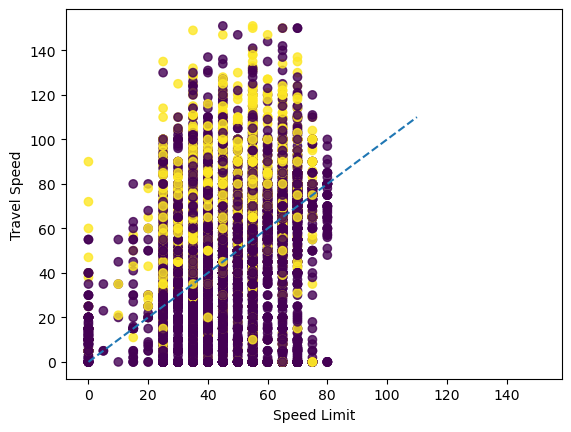

In [393]:
fig, ax = plt.subplots()

mask = (df.TRAV_SP.astype(int) < 200) & (df.VSPD_LIM.astype(int) < 90)
ax.scatter(df.VSPD_LIM.astype(int)[mask], 
           df.TRAV_SP.astype(int)[mask], 
           c = df.DR_DRINK.astype(int)[mask], alpha = 0.8)
ax.set_xlim(ax.get_ylim())

ax.set_xlabel("Speed Limit")
ax.set_ylabel("Travel Speed")

x = np.linspace(0, 110, 1000)
ax.plot(x, x, '--')
plt.show()

In [364]:
df.head()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,MODELNAME,VSPD_LIM,...,MAKENAME_Volkswagen,MAKENAME_Volvo,MAKENAME_Yamaha,VPICBODYCLASSNAME_Coupe,VPICBODYCLASSNAME_Hatchback/Liftback/Notchback,VPICBODYCLASSNAME_Minivan,VPICBODYCLASSNAME_Motorcycle,VPICBODYCLASSNAME_Pickup,VPICBODYCLASSNAME_Sedan/Saloon,VPICBODYCLASSNAME_Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)
0,3,1,67,145,0,80,2,1997,ES-250/300/300h/330/ 350,45,...,0,0,0,0,0,0,0,0,1,0
1,1,0,67,215,0,70,14,1995,Camry,65,...,0,0,0,0,0,0,0,0,1,0
2,1,0,73,133,0,80,15,2007,"Azera (For 2018 on, code as vehicle model 398)",35,...,0,0,0,0,0,0,0,0,1,0
3,1,0,64,115,0,70,0,2013,Suburban/Yukon XL (2004 on; see 431 for 1950- ...,45,...,0,0,0,0,0,0,0,0,0,1
4,1,0,71,185,0,55,16,2005,Mustang/Mustang II,55,...,0,0,0,1,0,0,0,0,0,0
